# **Experiment 01(A): Training with VGG-16 Model from scratch (Cifer100 Dataset)** #
## Name: Fahim Shahriar ##

## Dataset used: CIFAR100 ##
### About the dataset: ###
Structure of the Dataset
Each of the 100 fine classes belongs to one of 20 coarse classes. This hierarchical labeling allows for both fine-grained and coarse-grained classification tasks.

Coarse Classes (Superclasses) and Their Corresponding Fine Classes:
- Aquatic mammals: beaver, dolphin, otter, seal, whale
- Fish: aquarium fish, flatfish, ray, shark, trout
- Flowers: orchids, poppies, roses, sunflowers, tulips
- Food containers: bottles, bowls, cans, cups, plates
- Fruit and vegetables: apples, mushrooms, oranges, pears, sweet peppers
- Household electrical devices: clock, computer keyboard, lamp, telephone, television
- Household furniture: bed, chair, couch, table, wardrobe
- Insects: bee, beetle, butterfly, caterpillar, cockroach
- Large carnivores: bear, leopard, lion, tiger, wolf
- Large man-made outdoor things: bridge, castle, house, road, skyscraper
- Large natural outdoor scenes: cloud, forest, mountain, plain, sea
- Large omnivores and herbivores: camel, cattle, chimpanzee, elephant, kangaroo
- Medium-sized mammals: fox, porcupine, possum, raccoon, skunk
- Non-insect invertebrates: crab, lobster, snail, spider, worm
- People: baby, boy, girl, man, woman
- Reptiles: crocodile, dinosaur, lizard, snake, turtle
- Small mammals: hamster, mouse, rabbit, shrew, squirrel
- Trees: maple, oak, palm, pine, willow
- Vehicles 1: bicycle, bus, motorcycle, pickup truck, train
- Vehicles 2: lawn-mower, rocket, streetcar, tank, tractor

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from PIL import Image
import torchvision.datasets as dsets
from torchvision.transforms import v2 as transforms
from torchvision import models
import torch.optim as optim
from tqdm import tqdm
import torch
import torch.nn as nn
import pickle
import os
import torch.nn.functional as F
import requests
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sn
import pandas as pd
torch.manual_seed(1) # Set manual seed
from sklearn import preprocessing
from torch.utils.data import DataLoader, Dataset, Subset

# Define GPU device - We will run our model on GPU
gpu_device = torch.device("cuda")

import warnings
warnings.filterwarnings('ignore')

## Data Preparation

In [3]:
IMAGE_SIZE = 224

mean, std = [0.4914, 0.4822, 0.4465], [0.247, 0.243, 0.261]
# These values are mostly used by researchers as found to very useful in fast convergence

# Define the composed transformation for training
composed_train = transforms.Compose([
    transforms.RandomResizedCrop(IMAGE_SIZE),  # Resize the image to IMAGE_SIZE with a random crop
    transforms.RandomHorizontalFlip(),         # Randomly flip images horizontally    
    transforms.RandomRotation(10),             # Randomly rotate images by 10 degrees
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), fill=tuple([int(x*255) for x in mean])), # Random shift with nearest fill mode
    transforms.ToTensor(),                     # Convert image to tensor
    transforms.Normalize(mean, std)            # Normalize with standard mean and standard deviation
])         

# Define the transformations for the test set
composed_test = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),  # Resize to the expected input size of the model
    transforms.ToTensor(),                       # Convert to tensor
    transforms.Normalize(mean=mean, std=std)])


In [4]:
train_dataset = dsets.CIFAR100(root='./data', train=True, download=True, transform=composed_train)
val_dataset = dsets.CIFAR100(root='./data', train=False, download=True, transform=composed_test)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=64, shuffle=False)

100%|██████████| 169001437/169001437 [00:02<00:00, 70183307.34it/s]


Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified


## Visualization

Invalid shape (3, 224, 224) for image data
torch.Size([3, 224, 224]) torch.Size([224, 224, 3])


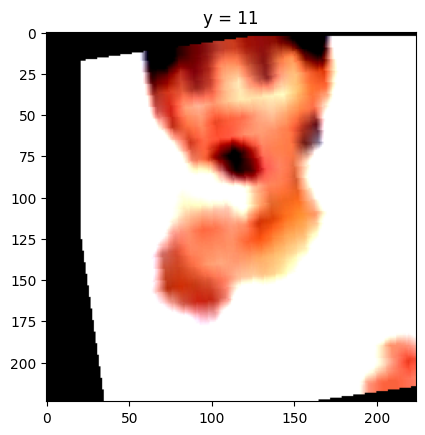

In [18]:
def show_data(img):
    try:
        plt.imshow(img[0])
    except Exception as e:
        print(e)
    print(img[0].shape, img[0].permute(1,2,0).shape)
    plt.imshow(img[0].permute(1,2,0))
    plt.title('y = '+ str(img[1]))
    plt.show()

# We need to convert the images to numpy arrays as tensors are not compatible with matplotlib.
def im_convert(tensor):
    #Lets
    img = tensor.cpu().clone().detach().numpy() #
    img = img.transpose(1, 2, 0)
    img = img * np.array(tuple(mean)) + np.array(tuple(std))
    img = img.clip(0, 1) # Clipping the size to print the images later
    return img

show_data(train_dataset[181])

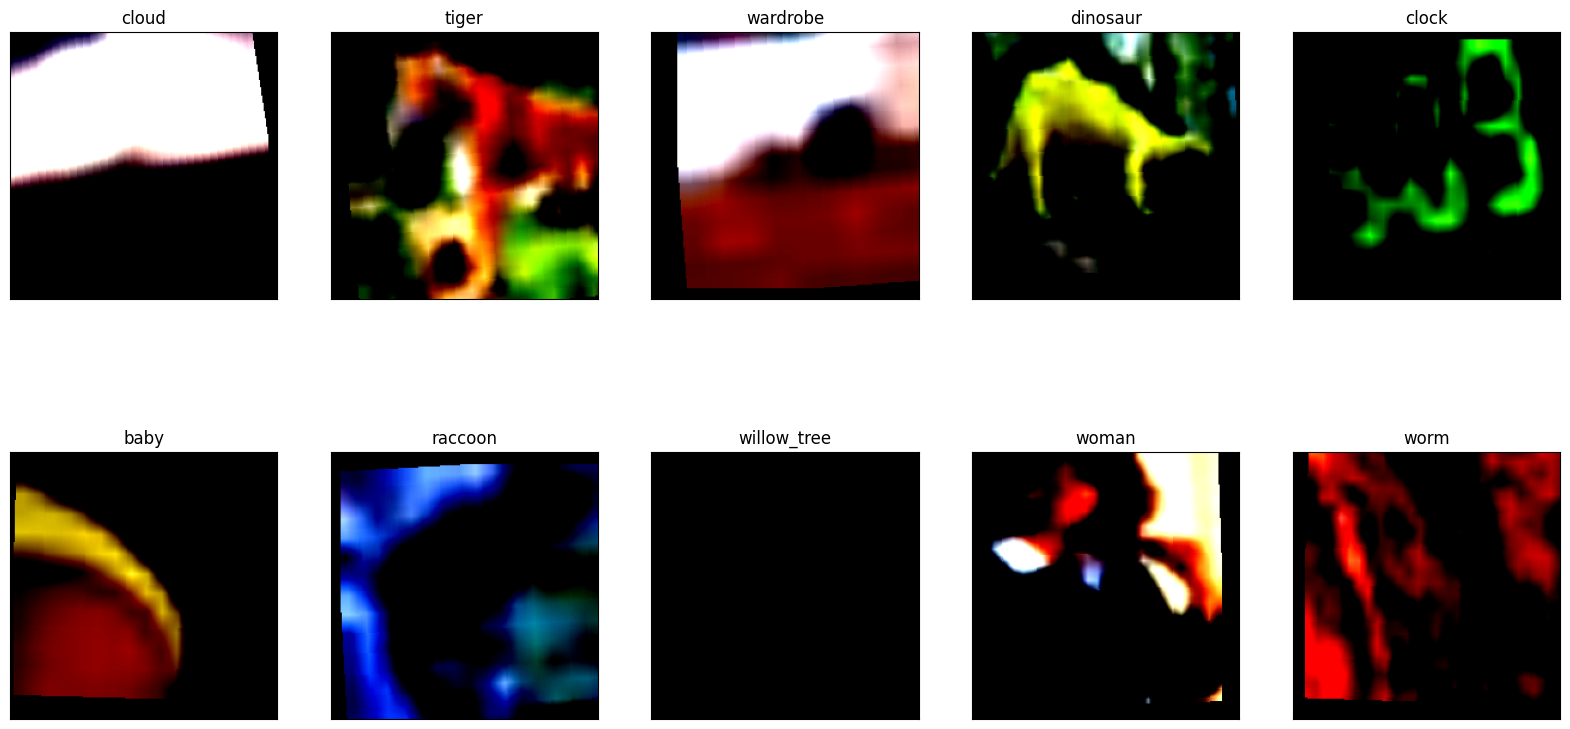

In [6]:
# CIFAR-100 class names
classes = train_dataset.classes

# Function to unnormalize and convert a tensor to a NumPy array
def im_convert(tensor):
    """Imconvert converts tensor to numpy array for matplotlib"""
    image = tensor.clone().detach().numpy()
    #image = image / 2 + 0.5  # unnormalize
    image = np.transpose(image, (1, 2, 0))
    return image

# Define an iterable on the data
data_iterable = iter(train_loader)
images, labels = next(data_iterable)  # getting the first batch of images and labels

# Initialize the figure
fig = plt.figure(figsize=(20, 10))

# Plot 10 images from the training dataset
for idx in np.arange(10):
    ax = fig.add_subplot(2, 5, idx+1, xticks=[], yticks=[])
    plt.imshow(im_convert(images[idx]))
    ax.set_title(classes[labels[idx].item()])

# Show the plot
plt.show()


## Model Train Function

In [7]:
# Training function with tqdm
def train_model(model, train_loader, validation_loader, optimizer, scheduler, criterion, patience=10, n_epochs=10):
    
    N_test = len(validation_loader.dataset)
    N_train = len(train_loader.dataset)
    train_accuracy_list = []
    val_accuracy_list = []
    train_cost_list = []
    val_cost_list = []

    val_loss_min = np.Inf
    patience_counter = 0

    for epoch in range(n_epochs):
        train_COST = 0
        train_correct = 0
        model.train()
        for x_train, y_train in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{n_epochs}", unit="batch"):
            x_train, y_train = x_train.to(gpu_device), y_train.to(gpu_device)
            optimizer.zero_grad()
            z = model(x_train)
            train_loss = criterion(z, y_train)
            _, yhat = torch.max(z.data, 1)
            train_correct += (yhat == y_train).sum().item()
            train_loss.backward()
            optimizer.step()
            train_COST += train_loss.item()

        train_COST /= len(train_loader)
        train_cost_list.append(train_COST)

        train_accuracy = train_correct / N_train
        train_accuracy_list.append(train_accuracy)

        # Validation
        val_COST = 0
        val_correct = 0
        model.eval()
        with torch.no_grad():
            for x_test, y_test in tqdm(validation_loader, desc=f"Epoch {epoch + 1}/{n_epochs}", unit="batch"):
                x_test, y_test = x_test.to(gpu_device), y_test.to(gpu_device)
                z = model(x_test)
                val_loss = criterion(z, y_test)
                _, yhat = torch.max(z.data, 1)
                val_correct += (yhat == y_test).sum().item()
                val_COST += val_loss.item()

        val_COST /= len(validation_loader)
        val_cost_list.append(val_COST)

        val_accuracy = val_correct / N_test
        val_accuracy_list.append(val_accuracy)

        print(f"--> Epoch Number : {epoch + 1} | Training Loss : {round(train_COST, 4)} | Validation Loss : {round(val_COST, 4)} | Train Accuracy : {round(train_accuracy * 100, 2)}% | Validation Accuracy : {round(val_accuracy * 100, 2)}%")

        # Step the scheduler
        scheduler.step(val_COST)

        if val_COST <= val_loss_min:
            print(f'Validation loss decreased ({val_loss_min:.6f} --> {val_COST:.6f}).  Saving model ...')
            torch.save(model.state_dict(), 'model_vgg16_cifar_p01A.pt')
            val_loss_min = val_COST
            patience_counter = 0
        else:
            patience_counter += 1
            print(f'EarlyStopping counter: {patience_counter} out of {patience}')
            if patience_counter >= patience:
                print('Early stopping triggered.')
                break

    return train_accuracy_list, val_accuracy_list, train_cost_list, val_cost_list

## Trassfer Learning: **VGG16** model from scratch
Without pretrained weights

In [8]:
# Define He initialization function
def he_init(m):
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

# Define the VGG-16 model function
def vgg_16():
    vgg = models.vgg16(pretrained=False)
    vgg.classifier[6] = nn.Linear(vgg.classifier[6].in_features, 100)
    vgg.apply(he_init)
    return vgg

# Define the model
model_vgg16_p = vgg_16()


In [11]:
pip install torchsummary

Note: you may need to restart the kernel to use updated packages.


In [12]:
from torchsummary import summary

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model_vgg16_p.to(device)

# Visualize the model
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

checking gpu usage

In [9]:
!nvidia-smi --query-gpu=memory.used --format=csv

memory.used [MiB]
0 MiB
0 MiB


In [11]:
torch.cuda.is_available()

True

In [ ]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
# Define model training hyperparameters
criterion = nn.CrossEntropyLoss()
learning_rate = 0.0001
weight_decay = 1e-06

# Initialize the optimizer with specified learning rate and decay
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Define the scheduler
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.1)

# Train the model
train_accuracy_list, val_accuracy_list, train_cost_list, val_cost_list = train_model(model=model, 
                                                            n_epochs=100,
                                                            train_loader=train_loader,
                                                            validation_loader=val_loader,
                                                            criterion=criterion,
                                                            scheduler=scheduler,
                                                            optimizer=optimizer)

Epoch 1/100: 100%|██████████| 157/157 [00:59<00:00,  2.64batch/s]


--> Epoch Number : 1 | Training Loss : 4.3274 | Validation Loss : 3.9277 | Train Accuracy : 3.41% | Validation Accuracy : 8.68%
Validation loss decreased (inf --> 3.927692).  Saving model ...


Epoch 2/100: 100%|██████████| 157/157 [00:59<00:00,  2.65batch/s]


--> Epoch Number : 2 | Training Loss : 3.9477 | Validation Loss : 3.5294 | Train Accuracy : 8.51% | Validation Accuracy : 15.35%
Validation loss decreased (3.927692 --> 3.529377).  Saving model ...


Epoch 3/100: 100%|██████████| 157/157 [00:59<00:00,  2.65batch/s]


--> Epoch Number : 3 | Training Loss : 3.7186 | Validation Loss : 3.32 | Train Accuracy : 12.6% | Validation Accuracy : 19.49%
Validation loss decreased (3.529377 --> 3.319970).  Saving model ...


Epoch 4/100: 100%|██████████| 157/157 [00:59<00:00,  2.65batch/s]


--> Epoch Number : 4 | Training Loss : 3.5328 | Validation Loss : 3.0899 | Train Accuracy : 16.15% | Validation Accuracy : 24.55%
Validation loss decreased (3.319970 --> 3.089930).  Saving model ...


Epoch 5/100: 100%|██████████| 157/157 [00:59<00:00,  2.66batch/s]


--> Epoch Number : 5 | Training Loss : 3.3857 | Validation Loss : 2.927 | Train Accuracy : 18.87% | Validation Accuracy : 28.0%
Validation loss decreased (3.089930 --> 2.927012).  Saving model ...


Epoch 6/100: 100%|██████████| 157/157 [00:59<00:00,  2.65batch/s]


--> Epoch Number : 6 | Training Loss : 3.2294 | Validation Loss : 2.7143 | Train Accuracy : 21.84% | Validation Accuracy : 31.49%
Validation loss decreased (2.927012 --> 2.714313).  Saving model ...


Epoch 7/100: 100%|██████████| 157/157 [00:59<00:00,  2.65batch/s]


--> Epoch Number : 7 | Training Loss : 3.0884 | Validation Loss : 2.541 | Train Accuracy : 24.22% | Validation Accuracy : 35.27%
Validation loss decreased (2.714313 --> 2.541049).  Saving model ...


Epoch 8/100: 100%|██████████| 157/157 [00:59<00:00,  2.65batch/s]


--> Epoch Number : 8 | Training Loss : 2.9505 | Validation Loss : 2.4433 | Train Accuracy : 26.98% | Validation Accuracy : 37.56%
Validation loss decreased (2.541049 --> 2.443290).  Saving model ...


Epoch 9/100: 100%|██████████| 157/157 [00:59<00:00,  2.65batch/s]


--> Epoch Number : 9 | Training Loss : 2.8397 | Validation Loss : 2.2746 | Train Accuracy : 29.2% | Validation Accuracy : 41.47%
Validation loss decreased (2.443290 --> 2.274583).  Saving model ...


Epoch 10/100: 100%|██████████| 157/157 [00:59<00:00,  2.65batch/s]


--> Epoch Number : 10 | Training Loss : 2.7232 | Validation Loss : 2.1505 | Train Accuracy : 31.62% | Validation Accuracy : 44.52%
Validation loss decreased (2.274583 --> 2.150469).  Saving model ...


Epoch 11/100: 100%|██████████| 157/157 [00:59<00:00,  2.65batch/s]


--> Epoch Number : 11 | Training Loss : 2.6222 | Validation Loss : 2.0933 | Train Accuracy : 33.75% | Validation Accuracy : 45.86%
Validation loss decreased (2.150469 --> 2.093305).  Saving model ...


Epoch 12/100: 100%|██████████| 157/157 [00:59<00:00,  2.65batch/s]


--> Epoch Number : 12 | Training Loss : 2.5442 | Validation Loss : 1.9933 | Train Accuracy : 35.26% | Validation Accuracy : 47.18%
Validation loss decreased (2.093305 --> 1.993327).  Saving model ...


Epoch 13/100: 100%|██████████| 157/157 [00:59<00:00,  2.65batch/s]


--> Epoch Number : 13 | Training Loss : 2.4627 | Validation Loss : 1.9302 | Train Accuracy : 37.34% | Validation Accuracy : 48.83%
Validation loss decreased (1.993327 --> 1.930180).  Saving model ...


Epoch 14/100: 100%|██████████| 157/157 [00:59<00:00,  2.65batch/s]


--> Epoch Number : 14 | Training Loss : 2.3831 | Validation Loss : 1.8046 | Train Accuracy : 38.79% | Validation Accuracy : 51.65%
Validation loss decreased (1.930180 --> 1.804649).  Saving model ...


Epoch 15/100: 100%|██████████| 157/157 [00:59<00:00,  2.65batch/s]


--> Epoch Number : 15 | Training Loss : 2.317 | Validation Loss : 1.7847 | Train Accuracy : 40.3% | Validation Accuracy : 51.99%
Validation loss decreased (1.804649 --> 1.784692).  Saving model ...


Epoch 16/100: 100%|██████████| 157/157 [00:59<00:00,  2.65batch/s]


--> Epoch Number : 16 | Training Loss : 2.2606 | Validation Loss : 1.6898 | Train Accuracy : 41.6% | Validation Accuracy : 54.44%
Validation loss decreased (1.784692 --> 1.689835).  Saving model ...


Epoch 17/100: 100%|██████████| 157/157 [00:59<00:00,  2.65batch/s]


--> Epoch Number : 17 | Training Loss : 2.1993 | Validation Loss : 1.7639 | Train Accuracy : 42.8% | Validation Accuracy : 53.87%
EarlyStopping counter: 1 out of 10


Epoch 18/100: 100%|██████████| 157/157 [00:59<00:00,  2.65batch/s]


--> Epoch Number : 18 | Training Loss : 2.1538 | Validation Loss : 1.6258 | Train Accuracy : 44.05% | Validation Accuracy : 55.73%
Validation loss decreased (1.689835 --> 1.625775).  Saving model ...


Epoch 19/100: 100%|██████████| 157/157 [00:59<00:00,  2.65batch/s]


--> Epoch Number : 19 | Training Loss : 2.1016 | Validation Loss : 1.6548 | Train Accuracy : 45.05% | Validation Accuracy : 56.38%
EarlyStopping counter: 1 out of 10


Epoch 20/100: 100%|██████████| 157/157 [00:59<00:00,  2.65batch/s]


--> Epoch Number : 20 | Training Loss : 2.0453 | Validation Loss : 1.5769 | Train Accuracy : 46.14% | Validation Accuracy : 57.4%
Validation loss decreased (1.625775 --> 1.576945).  Saving model ...


Epoch 21/100: 100%|██████████| 157/157 [00:59<00:00,  2.65batch/s]


--> Epoch Number : 21 | Training Loss : 1.9974 | Validation Loss : 1.576 | Train Accuracy : 47.58% | Validation Accuracy : 57.84%
Validation loss decreased (1.576945 --> 1.576017).  Saving model ...


Epoch 22/100: 100%|██████████| 157/157 [00:59<00:00,  2.65batch/s]


--> Epoch Number : 22 | Training Loss : 1.9668 | Validation Loss : 1.5732 | Train Accuracy : 48.14% | Validation Accuracy : 58.02%
Validation loss decreased (1.576017 --> 1.573186).  Saving model ...


Epoch 23/100: 100%|██████████| 157/157 [00:59<00:00,  2.65batch/s]


--> Epoch Number : 23 | Training Loss : 1.9264 | Validation Loss : 1.5328 | Train Accuracy : 49.37% | Validation Accuracy : 59.03%
Validation loss decreased (1.573186 --> 1.532846).  Saving model ...


Epoch 24/100: 100%|██████████| 157/157 [00:59<00:00,  2.65batch/s]


--> Epoch Number : 24 | Training Loss : 1.9011 | Validation Loss : 1.4863 | Train Accuracy : 50.05% | Validation Accuracy : 59.68%
Validation loss decreased (1.532846 --> 1.486316).  Saving model ...


Epoch 25/100: 100%|██████████| 157/157 [00:59<00:00,  2.65batch/s]


--> Epoch Number : 25 | Training Loss : 1.8586 | Validation Loss : 1.4599 | Train Accuracy : 51.21% | Validation Accuracy : 60.53%
Validation loss decreased (1.486316 --> 1.459879).  Saving model ...


Epoch 26/100: 100%|██████████| 157/157 [00:59<00:00,  2.65batch/s]


--> Epoch Number : 26 | Training Loss : 1.822 | Validation Loss : 1.4487 | Train Accuracy : 51.75% | Validation Accuracy : 60.79%
Validation loss decreased (1.459879 --> 1.448696).  Saving model ...


Epoch 27/100: 100%|██████████| 157/157 [00:59<00:00,  2.65batch/s]


--> Epoch Number : 27 | Training Loss : 1.8026 | Validation Loss : 1.4895 | Train Accuracy : 51.96% | Validation Accuracy : 60.29%
EarlyStopping counter: 1 out of 10


Epoch 28/100: 100%|██████████| 157/157 [00:59<00:00,  2.66batch/s]


--> Epoch Number : 28 | Training Loss : 1.764 | Validation Loss : 1.4781 | Train Accuracy : 52.94% | Validation Accuracy : 60.43%
EarlyStopping counter: 2 out of 10


Epoch 29/100: 100%|██████████| 157/157 [00:59<00:00,  2.66batch/s]


--> Epoch Number : 29 | Training Loss : 1.7457 | Validation Loss : 1.3688 | Train Accuracy : 53.63% | Validation Accuracy : 62.01%
Validation loss decreased (1.448696 --> 1.368781).  Saving model ...


Epoch 30/100: 100%|██████████| 157/157 [00:59<00:00,  2.65batch/s]


--> Epoch Number : 30 | Training Loss : 1.7144 | Validation Loss : 1.4267 | Train Accuracy : 54.26% | Validation Accuracy : 61.76%
EarlyStopping counter: 1 out of 10


Epoch 31/100: 100%|██████████| 157/157 [00:59<00:00,  2.65batch/s]


--> Epoch Number : 31 | Training Loss : 1.6918 | Validation Loss : 1.3933 | Train Accuracy : 54.68% | Validation Accuracy : 62.07%
EarlyStopping counter: 2 out of 10


Epoch 32/100: 100%|██████████| 157/157 [00:59<00:00,  2.65batch/s]


--> Epoch Number : 32 | Training Loss : 1.6741 | Validation Loss : 1.3894 | Train Accuracy : 55.42% | Validation Accuracy : 62.74%
EarlyStopping counter: 3 out of 10


Epoch 33/100: 100%|██████████| 157/157 [00:59<00:00,  2.65batch/s]


--> Epoch Number : 33 | Training Loss : 1.6421 | Validation Loss : 1.3665 | Train Accuracy : 56.43% | Validation Accuracy : 63.42%
Validation loss decreased (1.368781 --> 1.366493).  Saving model ...


Epoch 34/100: 100%|██████████| 157/157 [00:59<00:00,  2.65batch/s]


--> Epoch Number : 34 | Training Loss : 1.6095 | Validation Loss : 1.4223 | Train Accuracy : 56.85% | Validation Accuracy : 61.9%
EarlyStopping counter: 1 out of 10


Epoch 35/100: 100%|██████████| 157/157 [00:59<00:00,  2.64batch/s]


--> Epoch Number : 35 | Training Loss : 1.5908 | Validation Loss : 1.3354 | Train Accuracy : 57.3% | Validation Accuracy : 63.85%
Validation loss decreased (1.366493 --> 1.335354).  Saving model ...


Epoch 36/100: 100%|██████████| 157/157 [00:59<00:00,  2.65batch/s]


--> Epoch Number : 36 | Training Loss : 1.5804 | Validation Loss : 1.3961 | Train Accuracy : 57.62% | Validation Accuracy : 63.53%
EarlyStopping counter: 1 out of 10


Epoch 37/100: 100%|██████████| 157/157 [00:59<00:00,  2.66batch/s]


--> Epoch Number : 37 | Training Loss : 1.5551 | Validation Loss : 1.4035 | Train Accuracy : 58.2% | Validation Accuracy : 63.52%
EarlyStopping counter: 2 out of 10


Epoch 38/100: 100%|██████████| 157/157 [00:59<00:00,  2.65batch/s]


--> Epoch Number : 38 | Training Loss : 1.5359 | Validation Loss : 1.3052 | Train Accuracy : 58.9% | Validation Accuracy : 64.33%
Validation loss decreased (1.335354 --> 1.305183).  Saving model ...


Epoch 39/100: 100%|██████████| 157/157 [00:59<00:00,  2.66batch/s]


--> Epoch Number : 39 | Training Loss : 1.5153 | Validation Loss : 1.3684 | Train Accuracy : 59.13% | Validation Accuracy : 63.29%
EarlyStopping counter: 1 out of 10


Epoch 40/100: 100%|██████████| 157/157 [00:59<00:00,  2.65batch/s]


--> Epoch Number : 40 | Training Loss : 1.505 | Validation Loss : 1.3539 | Train Accuracy : 59.72% | Validation Accuracy : 64.61%
EarlyStopping counter: 2 out of 10


Epoch 41/100: 100%|██████████| 157/157 [00:59<00:00,  2.66batch/s]


--> Epoch Number : 41 | Training Loss : 1.4837 | Validation Loss : 1.3351 | Train Accuracy : 60.2% | Validation Accuracy : 64.37%
EarlyStopping counter: 3 out of 10


Epoch 42/100: 100%|██████████| 157/157 [00:59<00:00,  2.66batch/s]


--> Epoch Number : 42 | Training Loss : 1.4583 | Validation Loss : 1.3136 | Train Accuracy : 60.69% | Validation Accuracy : 64.28%
EarlyStopping counter: 4 out of 10


Epoch 43/100: 100%|██████████| 157/157 [00:59<00:00,  2.65batch/s]


--> Epoch Number : 43 | Training Loss : 1.4457 | Validation Loss : 1.2995 | Train Accuracy : 60.92% | Validation Accuracy : 65.21%
Validation loss decreased (1.305183 --> 1.299458).  Saving model ...


Epoch 44/100: 100%|██████████| 157/157 [00:59<00:00,  2.65batch/s]


--> Epoch Number : 44 | Training Loss : 1.4337 | Validation Loss : 1.3455 | Train Accuracy : 61.17% | Validation Accuracy : 65.32%
EarlyStopping counter: 1 out of 10


Epoch 45/100: 100%|██████████| 157/157 [00:59<00:00,  2.65batch/s]


--> Epoch Number : 45 | Training Loss : 1.4158 | Validation Loss : 1.365 | Train Accuracy : 61.85% | Validation Accuracy : 64.65%
EarlyStopping counter: 2 out of 10


Epoch 46/100: 100%|██████████| 157/157 [00:59<00:00,  2.66batch/s]


--> Epoch Number : 46 | Training Loss : 1.3966 | Validation Loss : 1.387 | Train Accuracy : 62.11% | Validation Accuracy : 65.68%
EarlyStopping counter: 3 out of 10


Epoch 47/100: 100%|██████████| 157/157 [00:59<00:00,  2.65batch/s]


--> Epoch Number : 47 | Training Loss : 1.3751 | Validation Loss : 1.3099 | Train Accuracy : 62.75% | Validation Accuracy : 65.56%
EarlyStopping counter: 4 out of 10


Epoch 48/100: 100%|██████████| 157/157 [00:59<00:00,  2.66batch/s]


--> Epoch Number : 48 | Training Loss : 1.3772 | Validation Loss : 1.3338 | Train Accuracy : 62.9% | Validation Accuracy : 65.47%
EarlyStopping counter: 5 out of 10


Epoch 49/100: 100%|██████████| 157/157 [00:59<00:00,  2.65batch/s]


--> Epoch Number : 49 | Training Loss : 1.3592 | Validation Loss : 1.3547 | Train Accuracy : 63.19% | Validation Accuracy : 65.57%
EarlyStopping counter: 6 out of 10


Epoch 50/100: 100%|██████████| 157/157 [00:59<00:00,  2.65batch/s]


--> Epoch Number : 50 | Training Loss : 1.2124 | Validation Loss : 1.2893 | Train Accuracy : 66.74% | Validation Accuracy : 67.49%
Validation loss decreased (1.299458 --> 1.289343).  Saving model ...


Epoch 51/100: 100%|██████████| 157/157 [00:59<00:00,  2.65batch/s]


--> Epoch Number : 51 | Training Loss : 1.1796 | Validation Loss : 1.288 | Train Accuracy : 67.67% | Validation Accuracy : 67.64%
Validation loss decreased (1.289343 --> 1.288004).  Saving model ...


Epoch 52/100:  18%|█▊        | 137/782 [02:17<10:45,  1.00s/batch]

In [57]:
train_accuracy = [3.41, 8.51, 12.6, 16.15, 18.87, 21.84, 24.22, 26.98, 29.2, 31.62, 33.75, 35.26, 37.34, 38.79, 40.3, 41.6, 42.8, 44.05, 45.05, 46.14, 47.58, 48.14, 49.37, 50.05, 51.21, 51.75, 51.96, 52.94, 53.63, 54.26, 54.68, 55.42, 56.43, 56.85, 57.3, 57.62, 58.2, 58.9, 59.13, 59.72, 60.2, 60.69, 60.92]
validation_accuracy = [8.68, 15.35, 19.49, 24.55, 28.0, 31.49, 35.27, 37.56, 41.47, 44.52, 45.86, 47.18, 48.83, 51.65, 51.99, 54.44, 53.87, 55.73, 56.38, 57.4, 57.84, 58.02, 59.03, 59.68, 60.53, 60.79, 60.29, 60.43, 62.01, 61.76, 62.07, 62.74, 63.42, 61.9, 63.85, 63.53, 63.52, 64.33, 63.29, 64.61, 64.37, 64.28, 65.21]
train_loss = [4.3274, 3.9477, 3.7186, 3.5328, 3.3857, 3.2294, 3.0884, 2.9505, 2.8397, 2.7232, 2.6222, 2.5442, 2.4627, 2.3831, 2.317, 2.2606, 2.1993, 2.1538, 2.1016, 2.0453, 1.9974, 1.9668, 1.9264, 1.9011, 1.8586, 1.822, 1.8026, 1.764, 1.7457, 1.7144, 1.6918, 1.6741, 1.6421, 1.6095, 1.5908, 1.5804, 1.5551, 1.5359, 1.5153, 1.505, 1.4837, 1.4583, 1.4457]
validation_loss = [3.9277, 3.5294, 3.32, 3.0899, 2.927, 2.7143, 2.541, 2.4433, 2.2746, 2.1505, 2.0933, 1.9933, 1.9302, 1.8046, 1.7847, 1.6898, 1.7639, 1.6258, 1.6548, 1.5769, 1.576, 1.5732, 1.5328, 1.4863, 1.4599, 1.4487, 1.4895, 1.4781, 1.3688, 1.4267, 1.3933, 1.3894, 1.3665, 1.4223, 1.3354, 1.3961, 1.4035, 1.3052, 1.3684, 1.3539, 1.3351, 1.3136, 1.2995]

In [58]:
train_accuracy = [3.41, 8.51, 12.6, 16.15, 18.87, 21.84, 24.22, 26.98, 29.2, 31.62, 33.75, 35.26, 37.34, 38.79, 40.3, 41.6, 42.8, 44.05, 45.05, 46.14, 47.58, 48.14, 49.37, 50.05, 51.21, 51.75, 51.96, 52.94, 53.63, 54.26, 54.68, 55.42, 56.43, 56.85, 57.3, 57.62, 58.2, 58.9, 59.13, 59.72, 60.2, 60.69, 60.92, 61.17, 61.85, 62.11, 62.75, 62.9, 63.19, 66.74, 67.67]
train_accuracy_p = [x / 100 for x in train_accuracy]

validation_accuracy = [8.68, 15.35, 19.49, 24.55, 28.0, 31.49, 35.27, 37.56, 41.47, 44.52, 45.86, 47.18, 48.83, 51.65, 51.99, 54.44, 53.87, 55.73, 56.38, 57.4, 57.84, 58.02, 59.03, 59.68, 60.53, 60.79, 60.29, 60.43, 62.01, 61.76, 62.07, 62.74, 63.42, 61.9, 63.85, 63.53, 63.52, 64.33, 63.29, 64.61, 64.37, 64.28, 65.21, 65.32, 64.65, 65.68, 65.56, 65.47, 65.57, 67.49, 67.64]
val_accuracy_p = [x / 100 for x in validation_accuracy]

train_loss = [4.3274, 3.9477, 3.7186, 3.5328, 3.3857, 3.2294, 3.0884, 2.9505, 2.8397, 2.7232, 2.6222, 2.5442, 2.4627, 2.3831, 2.317, 2.2606, 2.1993, 2.1538, 2.1016, 2.0453, 1.9974, 1.9668, 1.9264, 1.9011, 1.8586, 1.822, 1.8026, 1.764, 1.7457, 1.7144, 1.6918, 1.6741, 1.6421, 1.6095, 1.5908, 1.5804, 1.5551, 1.5359, 1.5153, 1.505, 1.4837, 1.4583, 1.4457, 1.4337, 1.4158, 1.3966, 1.3751, 1.3772, 1.3592, 1.2124, 1.1796]
validation_loss = [3.9277, 3.5294, 3.32, 3.0899, 2.927, 2.7143, 2.541, 2.4433, 2.2746, 2.1505, 2.0933, 1.9933, 1.9302, 1.8046, 1.7847, 1.6898, 1.7639, 1.6258, 1.6548, 1.5769, 1.576, 1.5732, 1.5328, 1.4863, 1.4599, 1.4487, 1.4895, 1.4781, 1.3688, 1.4267, 1.3933, 1.3894, 1.3665, 1.4223, 1.3354, 1.3961, 1.4035, 1.3052, 1.3684, 1.3539, 1.3351, 1.3136, 1.2995, 1.3455, 1.365, 1.387, 1.3099, 1.3338, 1.3547, 1.2893, 1.288]

print(len(train_accuracy))
print(len(validation_accuracy))
print(len(train_loss))
print(len(validation_loss))

51
51
51
51


In [20]:
model.load_state_dict(torch.load('/kaggle/input/part-01a-cifar100/pytorch/part01-a-model/1/model_vgg16_cifar_p01A.pt'))

<All keys matched successfully>

In [21]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
# Define model training hyperparameters
criterion = nn.CrossEntropyLoss()
learning_rate = 0.0001
weight_decay = 1e-06

# Initialize the optimizer with specified learning rate and decay
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Define the scheduler
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.1)

# Train the model
train_accuracy_list_, val_accuracy_list_, train_cost_list_, val_cost_list_ = train_model(model=model, 
                                                            n_epochs=20,
                                                            train_loader=train_loader,
                                                            validation_loader=val_loader,
                                                            criterion=criterion,
                                                            scheduler=scheduler,
                                                            optimizer=optimizer)

Epoch 1/20: 100%|██████████| 157/157 [00:59<00:00,  2.62batch/s]


--> Epoch Number : 1 | Training Loss : 1.4266 | Validation Loss : 1.3291 | Train Accuracy : 61.44% | Validation Accuracy : 65.46%
Validation loss decreased (inf --> 1.329134).  Saving model ...


Epoch 2/20: 100%|██████████| 157/157 [00:59<00:00,  2.63batch/s]


--> Epoch Number : 2 | Training Loss : 1.4233 | Validation Loss : 1.3153 | Train Accuracy : 61.61% | Validation Accuracy : 64.98%
Validation loss decreased (1.329134 --> 1.315315).  Saving model ...


Epoch 3/20: 100%|██████████| 157/157 [00:59<00:00,  2.64batch/s]


--> Epoch Number : 3 | Training Loss : 1.4138 | Validation Loss : 1.3436 | Train Accuracy : 62.04% | Validation Accuracy : 65.71%
EarlyStopping counter: 1 out of 10


Epoch 4/20: 100%|██████████| 157/157 [00:59<00:00,  2.65batch/s]


--> Epoch Number : 4 | Training Loss : 1.3796 | Validation Loss : 1.3466 | Train Accuracy : 62.54% | Validation Accuracy : 65.62%
EarlyStopping counter: 2 out of 10


Epoch 5/20: 100%|██████████| 157/157 [00:59<00:00,  2.64batch/s]


--> Epoch Number : 5 | Training Loss : 1.3673 | Validation Loss : 1.3587 | Train Accuracy : 63.1% | Validation Accuracy : 65.33%
EarlyStopping counter: 3 out of 10


Epoch 6/20: 100%|██████████| 157/157 [00:59<00:00,  2.65batch/s]


--> Epoch Number : 6 | Training Loss : 1.36 | Validation Loss : 1.3997 | Train Accuracy : 63.19% | Validation Accuracy : 64.86%
EarlyStopping counter: 4 out of 10


Epoch 7/20: 100%|██████████| 157/157 [00:59<00:00,  2.64batch/s]


--> Epoch Number : 7 | Training Loss : 1.3443 | Validation Loss : 1.3358 | Train Accuracy : 63.55% | Validation Accuracy : 65.73%
EarlyStopping counter: 5 out of 10


Epoch 8/20: 100%|██████████| 157/157 [00:59<00:00,  2.65batch/s]


--> Epoch Number : 8 | Training Loss : 1.332 | Validation Loss : 1.3821 | Train Accuracy : 63.91% | Validation Accuracy : 65.71%
EarlyStopping counter: 6 out of 10


Epoch 9/20: 100%|██████████| 157/157 [00:59<00:00,  2.65batch/s]


--> Epoch Number : 9 | Training Loss : 1.2022 | Validation Loss : 1.2749 | Train Accuracy : 67.45% | Validation Accuracy : 67.98%
Validation loss decreased (1.315315 --> 1.274922).  Saving model ...


Epoch 10/20: 100%|██████████| 157/157 [00:59<00:00,  2.65batch/s]


--> Epoch Number : 10 | Training Loss : 1.1526 | Validation Loss : 1.2811 | Train Accuracy : 68.44% | Validation Accuracy : 68.07%
EarlyStopping counter: 1 out of 10


Epoch 11/20: 100%|██████████| 157/157 [00:59<00:00,  2.65batch/s]


--> Epoch Number : 11 | Training Loss : 1.1313 | Validation Loss : 1.2941 | Train Accuracy : 69.12% | Validation Accuracy : 68.14%
EarlyStopping counter: 2 out of 10


Epoch 12/20: 100%|██████████| 157/157 [00:59<00:00,  2.65batch/s]


--> Epoch Number : 12 | Training Loss : 1.1142 | Validation Loss : 1.2955 | Train Accuracy : 69.59% | Validation Accuracy : 68.41%
EarlyStopping counter: 3 out of 10


Epoch 13/20: 100%|██████████| 157/157 [00:59<00:00,  2.64batch/s]


--> Epoch Number : 13 | Training Loss : 1.1235 | Validation Loss : 1.2984 | Train Accuracy : 69.61% | Validation Accuracy : 68.39%
EarlyStopping counter: 4 out of 10


Epoch 14/20: 100%|██████████| 157/157 [00:59<00:00,  2.63batch/s]


--> Epoch Number : 14 | Training Loss : 1.0972 | Validation Loss : 1.3 | Train Accuracy : 69.98% | Validation Accuracy : 68.58%
EarlyStopping counter: 5 out of 10


Epoch 15/20: 100%|██████████| 157/157 [00:59<00:00,  2.64batch/s]


--> Epoch Number : 15 | Training Loss : 1.1001 | Validation Loss : 1.3075 | Train Accuracy : 69.93% | Validation Accuracy : 68.49%
EarlyStopping counter: 6 out of 10


Epoch 16/20: 100%|██████████| 157/157 [00:59<00:00,  2.64batch/s]


--> Epoch Number : 16 | Training Loss : 1.0691 | Validation Loss : 1.3056 | Train Accuracy : 70.85% | Validation Accuracy : 68.47%
EarlyStopping counter: 7 out of 10


Epoch 17/20: 100%|██████████| 157/157 [00:59<00:00,  2.64batch/s]


--> Epoch Number : 17 | Training Loss : 1.082 | Validation Loss : 1.2985 | Train Accuracy : 70.49% | Validation Accuracy : 68.56%
EarlyStopping counter: 8 out of 10


Epoch 18/20: 100%|██████████| 157/157 [00:59<00:00,  2.64batch/s]


--> Epoch Number : 18 | Training Loss : 1.07 | Validation Loss : 1.3006 | Train Accuracy : 70.76% | Validation Accuracy : 68.7%
EarlyStopping counter: 9 out of 10


Epoch 19/20: 100%|██████████| 157/157 [00:59<00:00,  2.65batch/s]

--> Epoch Number : 19 | Training Loss : 1.0763 | Validation Loss : 1.2997 | Train Accuracy : 70.49% | Validation Accuracy : 68.7%
EarlyStopping counter: 10 out of 10
Early stopping triggered.


In [59]:
train_ac = train_accuracy_list_[8:]
val_ac = val_accuracy_list_[8:]
train_lo = train_cost_list_[8:]
val_lo = val_cost_list_[8:] 

In [60]:
train_accuracy_list = train_accuracy_p + train_ac
val_accuracy_list = val_accuracy_p + val_ac
train_cost_list = train_loss + train_lo
val_cost_list = validation_loss + val_lo

In [72]:
train_accuracy_list

[0.0341,
 0.0851,
 0.126,
 0.16149999999999998,
 0.1887,
 0.2184,
 0.2422,
 0.2698,
 0.292,
 0.31620000000000004,
 0.3375,
 0.35259999999999997,
 0.3734,
 0.38789999999999997,
 0.40299999999999997,
 0.41600000000000004,
 0.428,
 0.44049999999999995,
 0.45049999999999996,
 0.46140000000000003,
 0.4758,
 0.4814,
 0.49369999999999997,
 0.5005,
 0.5121,
 0.5175,
 0.5196000000000001,
 0.5294,
 0.5363,
 0.5426,
 0.5468,
 0.5542,
 0.5643,
 0.5685,
 0.573,
 0.5761999999999999,
 0.5820000000000001,
 0.589,
 0.5913,
 0.5972,
 0.602,
 0.6069,
 0.6092,
 0.6117,
 0.6185,
 0.6211,
 0.6275,
 0.629,
 0.6319,
 0.6674,
 0.6767,
 0.67454,
 0.68442,
 0.6912,
 0.6959,
 0.6961,
 0.69976,
 0.69934,
 0.7085,
 0.70488,
 0.70762,
 0.70494]

In [73]:
val_accuracy_list

[0.0868,
 0.1535,
 0.1949,
 0.2455,
 0.28,
 0.31489999999999996,
 0.3527,
 0.37560000000000004,
 0.4147,
 0.44520000000000004,
 0.4586,
 0.4718,
 0.48829999999999996,
 0.5165,
 0.5199,
 0.5444,
 0.5387,
 0.5573,
 0.5638000000000001,
 0.574,
 0.5784,
 0.5802,
 0.5903,
 0.5968,
 0.6053000000000001,
 0.6079,
 0.6029,
 0.6043,
 0.6201,
 0.6175999999999999,
 0.6207,
 0.6274000000000001,
 0.6342,
 0.619,
 0.6385000000000001,
 0.6353,
 0.6352,
 0.6433,
 0.6329,
 0.6461,
 0.6437,
 0.6428,
 0.6520999999999999,
 0.6531999999999999,
 0.6465000000000001,
 0.6568,
 0.6556000000000001,
 0.6547,
 0.6557,
 0.6748999999999999,
 0.6764,
 0.6798,
 0.6807,
 0.6814,
 0.6841,
 0.6839,
 0.6858,
 0.6849,
 0.6847,
 0.6856,
 0.687,
 0.687]

In [74]:
train_cost_list

[4.3274,
 3.9477,
 3.7186,
 3.5328,
 3.3857,
 3.2294,
 3.0884,
 2.9505,
 2.8397,
 2.7232,
 2.6222,
 2.5442,
 2.4627,
 2.3831,
 2.317,
 2.2606,
 2.1993,
 2.1538,
 2.1016,
 2.0453,
 1.9974,
 1.9668,
 1.9264,
 1.9011,
 1.8586,
 1.822,
 1.8026,
 1.764,
 1.7457,
 1.7144,
 1.6918,
 1.6741,
 1.6421,
 1.6095,
 1.5908,
 1.5804,
 1.5551,
 1.5359,
 1.5153,
 1.505,
 1.4837,
 1.4583,
 1.4457,
 1.4337,
 1.4158,
 1.3966,
 1.3751,
 1.3772,
 1.3592,
 1.2124,
 1.1796,
 1.2021549885992504,
 1.152624083983014,
 1.1312947450086588,
 1.114207142835383,
 1.1235124617433914,
 1.097216271683383,
 1.10011730154457,
 1.0690988261833825,
 1.0819644882246051,
 1.0700442580615772,
 1.076264234607482]

In [75]:
val_cost_list

[3.9277,
 3.5294,
 3.32,
 3.0899,
 2.927,
 2.7143,
 2.541,
 2.4433,
 2.2746,
 2.1505,
 2.0933,
 1.9933,
 1.9302,
 1.8046,
 1.7847,
 1.6898,
 1.7639,
 1.6258,
 1.6548,
 1.5769,
 1.576,
 1.5732,
 1.5328,
 1.4863,
 1.4599,
 1.4487,
 1.4895,
 1.4781,
 1.3688,
 1.4267,
 1.3933,
 1.3894,
 1.3665,
 1.4223,
 1.3354,
 1.3961,
 1.4035,
 1.3052,
 1.3684,
 1.3539,
 1.3351,
 1.3136,
 1.2995,
 1.3455,
 1.365,
 1.387,
 1.3099,
 1.3338,
 1.3547,
 1.2893,
 1.288,
 1.274921802198811,
 1.2811403107491268,
 1.2941132897783996,
 1.2955337106042606,
 1.2984447661478808,
 1.3000479792333712,
 1.307476751363961,
 1.3056322628525412,
 1.2985442576894335,
 1.3006449565765963,
 1.2997453429137067]

## Model Performance Report and Error Analysis

### Results of all the 62 epochs

In [61]:
def results_epoch(epochs, train_acc, val_acc, train_cost, val_cost):
    min_length = min(len(train_acc), len(val_acc), len(train_cost), len(val_cost), epochs)
    
    for epoch in range(min_length):
        print(f"Epoch {epoch + 1} ---> Train Accuracy: {train_acc[epoch] * 100:.3f}   |   Validation Accuracy: {val_acc[epoch] * 100:.3f}   |   Train Loss: {train_cost[epoch]:.3f}   |   Validation Loss: {val_cost[epoch]:.3f}\n")

# Example usage
results_epoch(
    epochs=62, 
    train_acc=train_accuracy_list, 
    val_acc=val_accuracy_list, 
    train_cost=train_cost_list, 
    val_cost=val_cost_list
)

Epoch 1 ---> Train Accuracy: 3.410   |   Validation Accuracy: 8.680   |   Train Loss: 4.327   |   Validation Loss: 3.928

Epoch 2 ---> Train Accuracy: 8.510   |   Validation Accuracy: 15.350   |   Train Loss: 3.948   |   Validation Loss: 3.529

Epoch 3 ---> Train Accuracy: 12.600   |   Validation Accuracy: 19.490   |   Train Loss: 3.719   |   Validation Loss: 3.320

Epoch 4 ---> Train Accuracy: 16.150   |   Validation Accuracy: 24.550   |   Train Loss: 3.533   |   Validation Loss: 3.090

Epoch 5 ---> Train Accuracy: 18.870   |   Validation Accuracy: 28.000   |   Train Loss: 3.386   |   Validation Loss: 2.927

Epoch 6 ---> Train Accuracy: 21.840   |   Validation Accuracy: 31.490   |   Train Loss: 3.229   |   Validation Loss: 2.714

Epoch 7 ---> Train Accuracy: 24.220   |   Validation Accuracy: 35.270   |   Train Loss: 3.088   |   Validation Loss: 2.541

Epoch 8 ---> Train Accuracy: 26.980   |   Validation Accuracy: 37.560   |   Train Loss: 2.950   |   Validation Loss: 2.443

Epoch 9 ---

### Visualizing

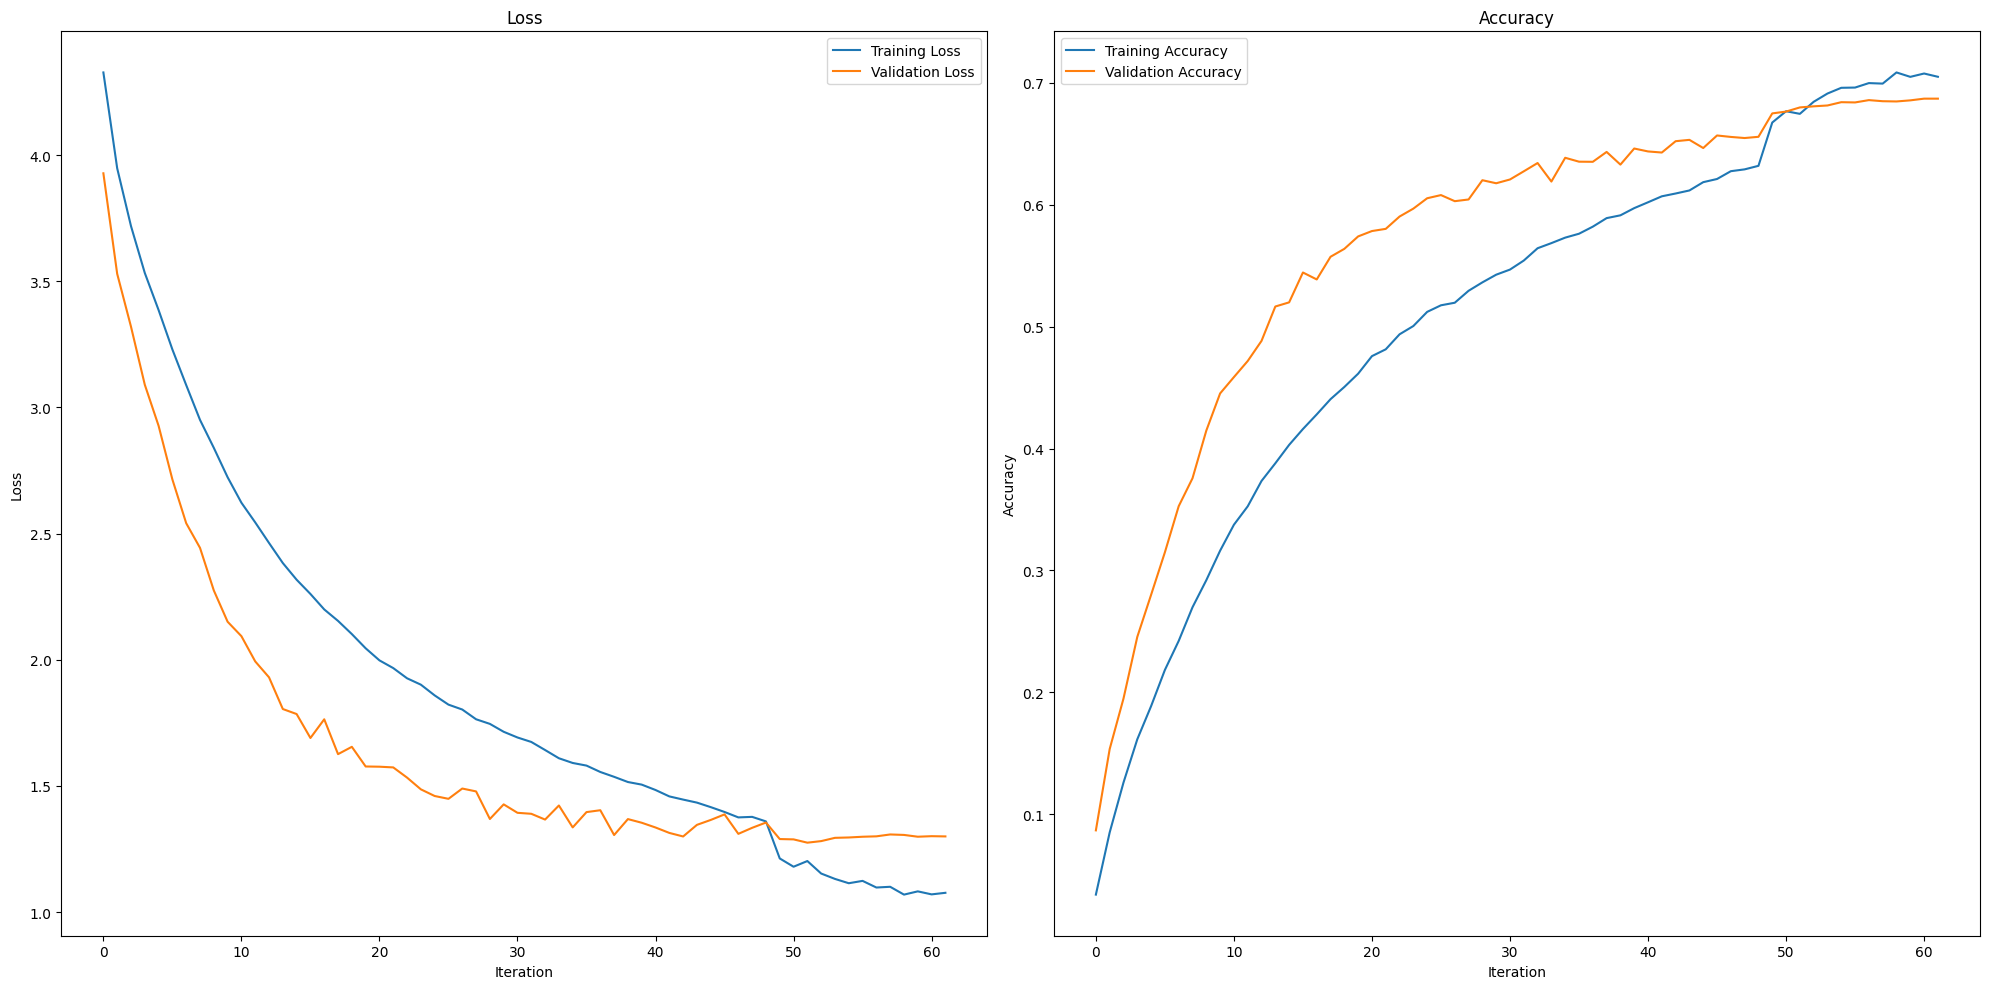

In [62]:
# Create a figure with 2 subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# Plot training and validation losses on the first subplot
ax1.plot(train_cost_list, label='Training Loss')
ax1.plot(val_cost_list, label='Validation Loss')
ax1.set_xlabel("Iteration")
ax1.set_ylabel("Loss")
ax1.set_title("Loss")
ax1.legend()

# Plot training and validation accuracies on the second subplot
ax2.plot(train_accuracy_list, label='Training Accuracy')
ax2.plot(val_accuracy_list, label='Validation Accuracy')
ax2.set_xlabel("Iteration")
ax2.set_ylabel("Accuracy")
ax2.set_title("Accuracy")
ax2.legend()

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()


### Classification Report

In [63]:
# Lists to store true labels and predictions
y_pred = []
y_true = []

# Iterate over validation data
for x, y in torch.utils.data.DataLoader(dataset=val_dataset, batch_size=1):
    x = x.to(gpu_device)
    y = y.to(gpu_device)
    
    # Forward pass
    with torch.no_grad():
        z = model(x)
        _, yhat = torch.max(z, 1)
        pred = yhat.data.cpu().numpy()
        y_pred.extend(pred)  # Save prediction
        
        labels = y.data.cpu().numpy()
        y_true.extend(labels)  # Save truth

# Generate classification report
report = classification_report(y_true, y_pred, target_names=[str(i) for i in classes])
print(report)


               precision    recall  f1-score   support

        apple       0.87      0.89      0.88       100
aquarium_fish       0.85      0.82      0.83       100
         baby       0.66      0.63      0.64       100
         bear       0.68      0.50      0.58       100
       beaver       0.49      0.55      0.52       100
          bed       0.64      0.76      0.70       100
          bee       0.73      0.72      0.72       100
       beetle       0.70      0.71      0.71       100
      bicycle       0.76      0.78      0.77       100
       bottle       0.77      0.79      0.78       100
         bowl       0.55      0.47      0.51       100
          boy       0.50      0.58      0.54       100
       bridge       0.73      0.84      0.78       100
          bus       0.66      0.61      0.64       100
    butterfly       0.60      0.63      0.61       100
        camel       0.66      0.71      0.69       100
          can       0.61      0.71      0.65       100
       ca

In [64]:
report_dict = classification_report(y_true, y_pred, target_names=[str(i) for i in classes], output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()
report_df

,precision,recall,f1-score,support
apple,0.872549,0.890,0.881188,100.000
aquarium_fish,0.845361,0.820,0.832487,100.000
baby,0.656250,0.630,0.642857,100.000
bear,0.684932,0.500,0.578035,100.000
beaver,0.486726,0.550,0.516432,100.000
...,...,...,...,...
woman,0.568182,0.500,0.531915,100.000
worm,0.708333,0.680,0.693878,100.000
accuracy,0.687000,0.687,0.687000,0.687
macro avg,0.688610,0.687,0.685640,10000.000


### Convertinng classification report into docx file

In [66]:
pip install python-docx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.3/244.3 kB 1.7 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [70]:
from docx import Document
from docx.shared import Pt

report_df = report_df.applymap(lambda x: f'{x:.4f}' if isinstance(x, float) else x)

# Save the DataFrame as a Word document
doc = Document()

# Add a title
doc.add_heading('Classification Report-01A', level=1)

# Add a table
table = doc.add_table(rows=1, cols=len(report_df.columns) + 1)
table.style = 'Table Grid'

# Add the header row
hdr_cells = table.rows[0].cells
hdr_cells[0].text = 'Class'
for i, column_name in enumerate(report_df.columns):
    hdr_cells[i + 1].text = column_name

# Add the data rows
for idx, row in report_df.iterrows():
    row_cells = table.add_row().cells
    row_cells[0].text = str(idx)
    for i, value in enumerate(row):
        row_cells[i + 1].text = str(value)

# Save the document
doc.save('classification_report-01A.docx')

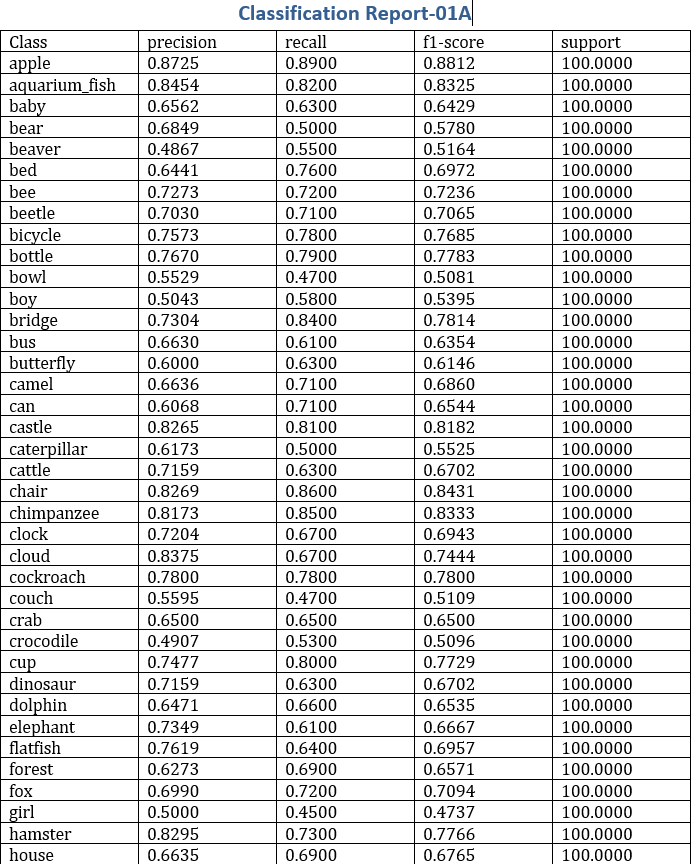

### ROC plot

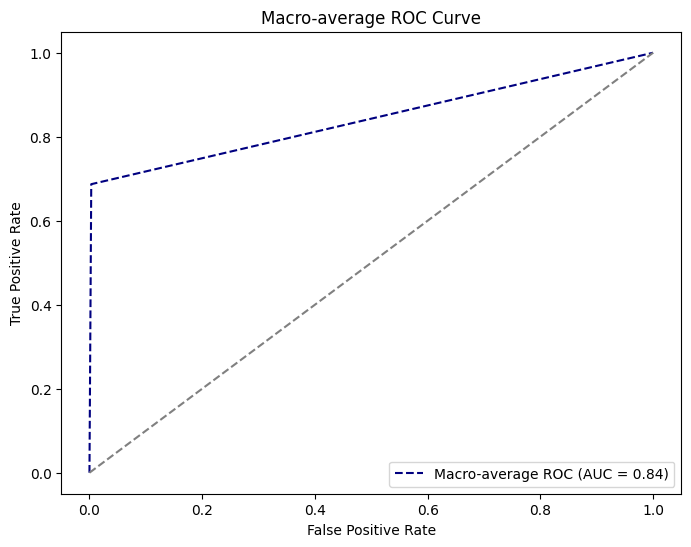

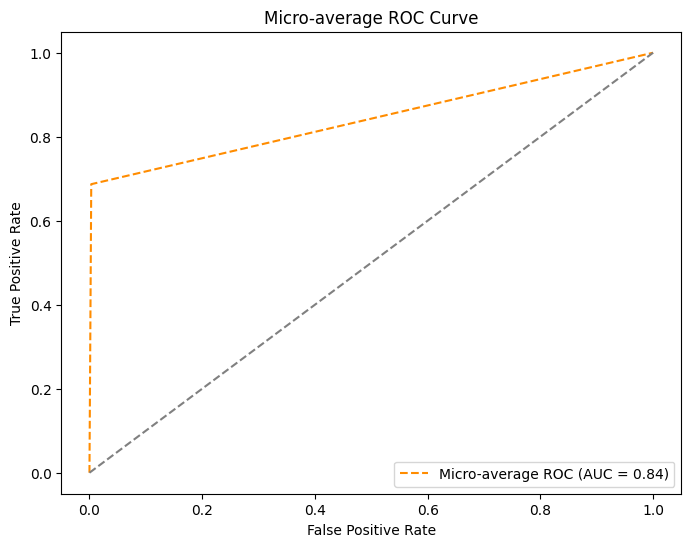

In [68]:
from sklearn.metrics import roc_curve, auc

# Convert lists to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Check if y_pred is 1D (representing class predictions) or 2D (representing probabilities/scores)
if len(y_pred.shape) == 1:
    # Convert class predictions to one-hot encoded format
    y_pred_one_hot = np.zeros((len(y_true), np.max(y_pred) + 1))
    y_pred_one_hot[np.arange(len(y_true)), y_pred] = 1
    y_pred = y_pred_one_hot

# Compute the number of classes
num_classes = y_pred.shape[1]

# If y_true is one-dimensional, convert it to one-hot encoded format
if len(y_true.shape) == 1:
    y_true_one_hot = np.zeros((len(y_true), num_classes))
    y_true_one_hot[np.arange(len(y_true)), y_true] = 1
    y_true = y_true_one_hot

# Initialize lists to store fpr and tpr for each class
all_fpr = []
all_tpr = []
all_auc = []

# Compute ROC curve and AUC for each class
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc = auc(fpr, tpr)
    all_fpr.append(fpr)
    all_tpr.append(tpr)
    all_auc.append(roc_auc)

# Compute the macro-average ROC curve by averaging the fpr and tpr across all classes
mean_fpr = np.mean(all_fpr, axis=0)
mean_tpr = np.mean(all_tpr, axis=0)

# Compute the macro-average AUC
macro_auc = auc(mean_fpr, mean_tpr)

# Plot the macro-average ROC curve
plt.figure(figsize=(8, 6))
plt.plot(mean_fpr, mean_tpr, label=f'Macro-average ROC (AUC = {macro_auc:.2f})', color='navy', linestyle='--')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Macro-average ROC Curve')
plt.legend(loc='lower right')
plt.show()

# Compute micro-average ROC curve and AUC
micro_fpr, micro_tpr, _ = roc_curve(y_true.ravel(), y_pred.ravel())
micro_auc = auc(micro_fpr, micro_tpr)

# Plot the micro-average ROC curve
plt.figure(figsize=(8, 6))
plt.plot(micro_fpr, micro_tpr, label=f'Micro-average ROC (AUC = {micro_auc:.2f})', color='darkorange', linestyle='--')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Micro-average ROC Curve')
plt.legend(loc='lower right')
plt.show()


## Miss-classification

Invalid shape (3, 224, 224) for image data
torch.Size([3, 224, 224]) torch.Size([224, 224, 3])


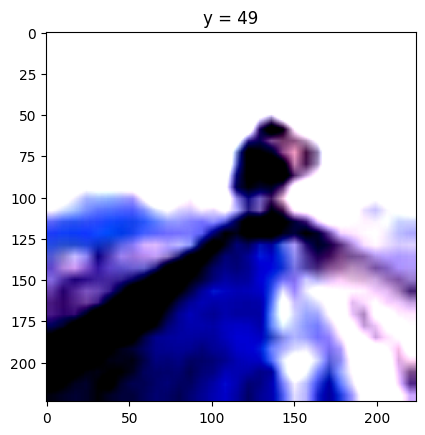

True label:  mountain
Predicted label:  bridge

---------------------------------------------------------------------

Invalid shape (3, 224, 224) for image data
torch.Size([3, 224, 224]) torch.Size([224, 224, 3])


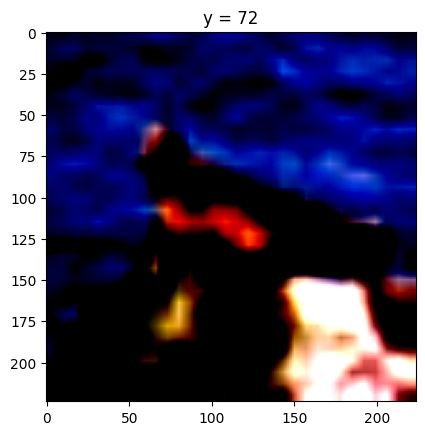

True label:  seal
Predicted label:  otter

---------------------------------------------------------------------

Invalid shape (3, 224, 224) for image data
torch.Size([3, 224, 224]) torch.Size([224, 224, 3])


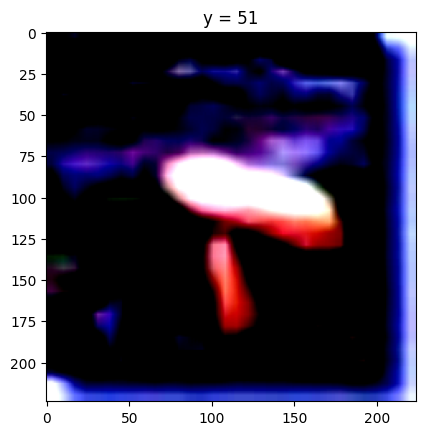

True label:  mushroom
Predicted label:  streetcar

---------------------------------------------------------------------

Invalid shape (3, 224, 224) for image data
torch.Size([3, 224, 224]) torch.Size([224, 224, 3])


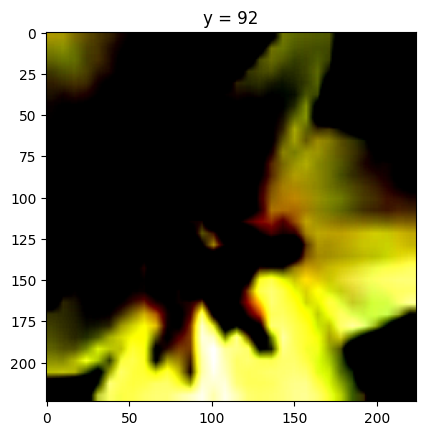

True label:  tulip
Predicted label:  spider

---------------------------------------------------------------------



In [69]:
classes_ = val_dataset.classes

# Set the model to evaluation mode
model.eval()

count = 0
i = 0

for x, y in torch.utils.data.DataLoader(dataset=val_dataset, batch_size=1):
    x = x.to(gpu_device)
    y = y.to(gpu_device)
    z = model(x)
    _, yhat = torch.max(z, 1)

    if yhat != y:
        show_data(val_dataset[i])
        print("True label: ", classes_[y.item()])
        print("Predicted label: ", classes_[yhat.item()])
        plt.show()
        count += 1

        print('\n---------------------------------------------------------------------\n')

    if count >= 4:
        break

    i += 1

# Short Report
## Experiment 01A

Device used to conduct this experiment: Nvidia RTX3070ti 8GB

Framework: Pytorch

Augmentation used: Random resized crop, Random horizontal flip, Random rotation, Random affine

Batch size = 64

Optimizer used: Adam (lr:0.0001)

Regularisation techniques used:  Early stopping with patience 10, Weight decay

Others: 
- In this study, the ReduceLROnPlateau learning rate scheduler was employed to dynamically adjust the learning rate based on the validation loss with patience 5.
- The He initializer was utilized to initialize the network weights to maintain a good distribution and improve convergence during training.

Key points:
-  This model achieved around 68.7% accuracy and stopped training at 62 epochs
-  An average Macro and Micro AUC was found to be 0.84
-  It took around 14 hours and 37 minutes to finish the training